In [8]:
#anobii it shared
import pandas as pd
sh_ano_IT=pd.read_csv("C:\\Users\\Fossati\\Desktop\\Tesi\\Dati\\Dati_SharedBooks\\Italiano\\Anobii_shared_reviews.csv")
sh_ano_IT.columns

Index(['Unnamed: 0', 'Genere', 'Title', 'ISBN', 'Username', 'Rating', 'Date',
       'N_Likes', 'Review_Content'],
      dtype='object')

In [9]:
#anobii it shared

sh_ama_IT=pd.read_csv("C:\\Users\\Fossati\\Desktop\\Tesi\\Dati\\Dati_SharedBooks\\Italiano\\AmazonIT_shared_reviews.csv")
sh_ama_IT.columns

Index(['Unnamed: 0', 'Genere', 'Title', 'ISBN', 'Username', 'Stars_AZ',
       'Rev_Date_AZ', 'Rev_Place_AZ', 'N_Likes_AZ', 'Rev_Content_AZ'],
      dtype='object')

In [10]:
# anobii IT

ano_IT=pd.read_csv("C:\\Users\\Fossati\\Desktop\\Tesi\\Dati\\Dati_Italia\\anobii_rev_ita.csv")
ano_IT.columns

Index(['Unnamed: 0', 'index', 'Unnamed: 0.1', 'Genere', 'Title', 'ISBN',
       'Username', 'Rating', 'Date', 'N_Likes', 'Review_Content',
       'Language_AN'],
      dtype='object')

In [11]:
# amazon IT


ama_IT=pd.read_csv("C:\\Users\\Fossati\\Desktop\\Tesi\\Dati\\Dati_Italia\\amazon_rev_ita.csv")
ama_IT.columns

Index(['Unnamed: 0', 'index', 'Unnamed: 0.1', 'Genere', 'ISBN', 'Language_AZ',
       'N_Likes_AZ', 'Rev_Content_AZ', 'Rev_Date_AZ', 'Rev_Place_AZ',
       'Stars_AZ', 'Title', 'Username'],
      dtype='object')

In [12]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizerFast
from transformers import Trainer, TrainingArguments
# For data manipulation and analysis
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

import torch

In [13]:
def prediction_test_nolabels(dataset,colname):  #dataset fa riferimento al set di dati che vogliamo passare, modello dipende dal tipo di FT
#poi ci sarà anche la funzione per predire senza labels
  from IPython.utils import io
  with io.capture_output() as captured: #non vogliamo i print che intasano la ram
  
  #print("This wont print")
    tok = XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-base')
    mod = XLMRobertaForSequenceClassification.from_pretrained('Polarity_fin_xlmr') #modello migliore ottenuto
   
    unique_labels={'Neutra', 'Positiva', 'Negativa'}
    label2id={'Negativa': 2, 'Neutra': 0, 'Positiva': 1}
    id2label={2:'Negativa', 0:'Neutra', 1:'Positiva'}
    
    training_args = TrainingArguments(
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    learning_rate=2e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=2000,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',
    save_strategy='no'# evaluate during fine-tuning so that we can see progress 
    )
    
    class MyDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels) 
    
    #test_texts=dataset[colname] #sentence
    
    #da qui parte il codice
    frasi=dataset[colname].tolist()
     
    prediction=[]  #lista che sarà riempita con le predizioni
    score=[]#lista che sarà riempita con gli punt
    #entrambe saranno incollate ai dataset alla fine
    to_drop=['',' ','.',',','!']
    count=0
    print_c=[15000, 50000, 100000, 150000, 200000, 250000]
    frasi_pred=[]
    for el in frasi:
        count+=1
        punt=0
        spl=el.replace("!","!.").replace("?","?.").replace("|",".").split(".")#e ottengo una lista di stringhe
        
        test_texts=[] #lista frasi pulite
        for stringa in spl:
            if stringa not in to_drop:
                test_texts.append(stringa)
            
        test_labels=['Neutra'] * len(test_texts)  #lista casuale con labels, per non cambiare la struttura del codice al fine di poterlo usare anche senza labels per fare testing

        test_encodings  = tok(test_texts, truncation=True, padding=True, max_length=128) #, return_tensors='pt'
        test_labels_encoded  = [label2id[y] for y in test_labels]

        test_dataset = MyDataset(test_encodings, test_labels_encoded)
        

        trainer = Trainer(model=mod, args=training_args)  #basta avere il modello come parametro

        predicted_results=trainer.predict(test_dataset)
    
        predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
        predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
        predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability
        
        for pred in predicted_labels: 
            frasi_pred.append(pred)
            if pred == 'Neutra':
                punt+=0
            elif pred == 'Positiva':
                punt+=2.5
            elif pred == 'Negativa':
                punt+=-2.5
        
        try:
            punteggio=round(float(punt/len(predicted_labels)),2)
            score.append(punteggio) #appendiamo risultato alla lista score
        except:
            score.append('error')
            prediction.append('Neutra')
        
        if punteggio <= -1.5:
            prediction.append('Fortemente_Negativa')
        elif punteggio >= 1.5:
            prediction.append('Fortemente_Positiva')
        elif punteggio < 1.5 and punteggio > 0.5:
            prediction.append('Positiva')
        elif punteggio > -1.5 and punteggio < -0.5:
            prediction.append('Negativa')
        else:
            prediction.append('Neutra')
            
        if count in print_c:
            print(count)
        


    return prediction, score, frasi_pred

In [ ]:
#prova con set ampio di recensioni

In [ ]:
sh_an=prediction_test_nolabels(sh_ano_IT.sample(5000),'Review_Content')  #variabilizza o sei finito
#sh_good_EN['Sentiment']=sh_gr

In [ ]:
sh_am=prediction_test_nolabels(sh_ama_IT.sample(5000),'Rev_Content_AZ')  #variabilizza o sei finito
#sh_good_EN['Sentiment']=sh_gr

In [47]:
import numpy as np
print(np.mean(sh_an[1]))
print(np.median(sh_an[1]))
print(np.std(sh_an[1]))

0.6769413333333333
0.62
1.085912945202433


In [48]:
import numpy as np
print(np.mean(sh_am[1]))
print(np.median(sh_am[1]))
print(np.std(sh_am[1]))

1.0977033333333333
1.25
1.20498062999185


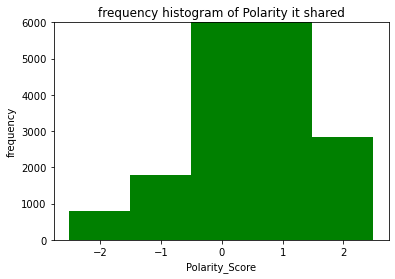

In [49]:
#normalità della distribuzione?

import matplotlib.pyplot as plt

bins=np.arange(-2.51,2.51,1) 
#min = 3.45
#max= 4.9

        
plt.hist(sh_an[1]+sh_am[1], bins, color='green')
plt.ylabel('frequency')
plt.xlabel('Polarity_Score')
plt.ylim((0,6000))
plt.title('frequency histogram of Polarity it shared')
plt.show()

# si puo' assumere normalita'
    

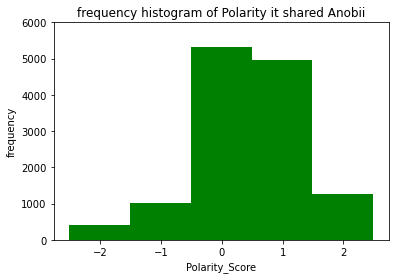

In [50]:
#normalità della distribuzione?

import matplotlib.pyplot as plt

bins=np.arange(-2.51,2.51,1) 
#min = 3.45
#max= 4.9

        
plt.hist(sh_an[1], bins, color='green')
plt.ylabel('frequency')
plt.xlabel('Polarity_Score')
plt.ylim((0,6000))
plt.title('frequency histogram of Polarity it shared Anobii')
plt.show()

# si puo' assumere normalita'
    

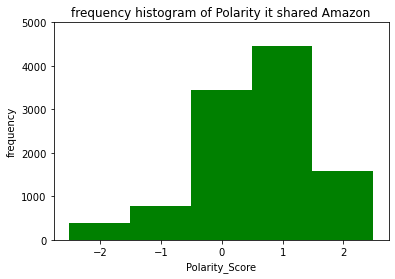

In [53]:
#normalità della distribuzione?

import matplotlib.pyplot as plt

bins=np.arange(-2.51,2.51,1) 
#min = 3.45
#max= 4.9

        
plt.hist(sh_am[1], bins, color='green')
plt.ylabel('frequency')
plt.xlabel('Polarity_Score')
plt.ylim((0,5000))
plt.title('frequency histogram of Polarity it shared Amazon')
plt.show()

# si puo' assumere normalita'
    

In [52]:
pd.DataFrame(sh_am[0]+sh_an[0]).groupby(0).size()

0
Fortemente_Negativa     813
Fortemente_Positiva    9250
Negativa               1756
Neutra                 9437
Positiva               8744
dtype: int64

In [ ]:
#sbilanciamento a favore delle postive, d'altronde i rating medi sono alti, e comunque sono i bestellers

In [ ]:
#prova per frasi

In [54]:
pd.DataFrame(sh_am[2]+sh_an[2]).groupby(0).size()

0
Negativa    14826
Neutra      78305
Positiva    48599
dtype: int64

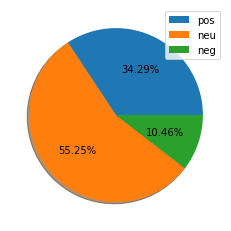

In [55]:
import matplotlib.pyplot as plt
import numpy as np
def pie(lista):
    y = np.array(lista)
    mylabels = ["pos","neu","neg"]
    plt.pie(y, shadow = True,autopct='%.2f%%')#labels= percent
    plt.legend(mylabels,loc="upper right")
    return plt.show() 
pie([48599, 78305, 14826])

In [ ]:
sh_an=prediction_test_nolabels(sh_ano_IT,'Review_Content')  
print(len(sh_an[0]))
print(len(sh_an[1]))

In [16]:
pd.DataFrame(sh_an[0]).groupby(0).size()

0
Fortemente_Negativa    1508
Fortemente_Positiva    9508
Negativa               2214
Neutra                 8313
Positiva               7565
dtype: int64

In [19]:
sh_ano_IT['Sentiment']=sh_an[0]
sh_ano_IT['Sent_Score']=sh_an[1]
sh_ano_IT.to_csv('Anobii_shared_reviews.csv')

In [ ]:
sh_am=prediction_test_nolabels(sh_ama_IT,'Rev_Content_AZ') 
print(len(sh_am[0]))
print(len(sh_am[1]))

In [17]:
pd.DataFrame(sh_am[0]).groupby(0).size()

0
Fortemente_Negativa     610
Fortemente_Positiva    9366
Negativa                667
Neutra                 2064
Positiva               2716
dtype: int64

In [20]:
sh_ama_IT['Sentiment']=sh_am[0]
sh_ama_IT['Sent_Score']=sh_am[1]
sh_ama_IT.to_csv('AmazonIT_shared_reviews.csv')

In [ ]:
an=prediction_test_nolabels(ano_IT,'Review_Content')  
print(len(an[0]))
print(len(an[1]))

In [24]:
pd.DataFrame(an[0]).groupby(0).size()

0
Fortemente_Negativa     3134
Fortemente_Positiva    21985
Negativa                4739
Neutra                 16984
Positiva               16915
dtype: int64

In [25]:
ano_IT['Sentiment']=an[0]
ano_IT['Sent_Score']=an[1]
ano_IT.to_csv('anobii_rev_ita.csv')

In [ ]:
am=prediction_test_nolabels(ama_IT,'Rev_Content_AZ') 
print(len(am[0]))
print(len(am[1]))

In [27]:
pd.DataFrame(am[0]).groupby(0).size()

0
Fortemente_Negativa     3742
Fortemente_Positiva    58377
Negativa                3750
Neutra                 11141
Positiva               16201
dtype: int64

In [28]:
ama_IT['Sentiment']=am[0]
ama_IT['Sent_Score']=am[1]
ama_IT.to_csv('amazon_rev_ita.csv')